# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## package dependencies

In [2]:
!pip install kaggle

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import json

In [4]:
import sys
sys.path.append("/notebooks")

In [5]:
import fastai

# Kaggle Setup 

- generate api key from [Kaggle](https://www.kaggle.com)
- click "My Account" -> "Create New Api Token"
- replace the cell below with json

In [6]:
kaggle_token="""
{"username":"npatta01","key":"fdb61255c18946aa1b04763a86f7e7fd"}
"""

save kaggle_token to correct place

In [9]:
!echo {json.dumps(kaggle_token)}

/bin/sh: 1: Syntax error: "(" unexpected


In [6]:
!mkdir -p /home/ubuntu/.kaggle
!echo {json.dumps(kaggle_token)} > /home/ubuntu/.kaggle/kaggle.json
#!chmod 600 /home/ubuntu/.kaggle/kaggle.json

/bin/sh: 1: Syntax error: "(" unexpected


download the dataset

In [8]:
!kaggle competitions download -c dog-breed-identification

labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls /root/.kaggle/competitions/dog-breed-identification

In [ ]:
!ls /root/.kaggle/competitions/dog-breed-identification/*.zip

In [9]:
PATH = "/root/.kaggle/competitions/dog-breed-identification"

- data has labels, sample submissions, test images, train images

In [ ]:
!unzip -o {PATH}/labels.csv.zip -d {PATH}
!unzip -o {PATH}/sample_submission.csv.zip -d {PATH}
!unzip -o {PATH}/test.zip -d {PATH}
!unzip -o {PATH}/train.zip -d {PATH}

In [10]:
!ls {PATH}

labels.csv	sample_submission.csv	   test      train
labels.csv.zip	sample_submission.csv.zip  test.zip  train.zip


# Imports

In [11]:
from fastai.conv_learner import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.dataset import get_cv_idxs
import fastai
import pandas as pd
import fastai.dataset 


# Model Architecture

In [12]:
sz=224
arch=resnet34
#bs=64
bs=32

# explore dataset

In [13]:
labels_df = pd.read_csv(f'{PATH}/labels.csv')

In [14]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
labels_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [16]:
?get_cv_idxs

In [17]:
label_csv = f'{PATH}/labels.csv'
n = len(list(open(label_csv))) -1
val_idxs = get_cv_idxs(n=n,val_pct=0.2)
n , len(val_idxs)

(10222, 2044)

In [26]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}/labels.csv'
                                        , tfms= tfms, bs=bs
                                        , val_idxs = val_idxs
                                        , suffix =".jpg"
                                        , test_name='test'
                                        )
    return data.resize(sz, 'tmp')


great question.      
Since we have max_zoom=1.1,    
I figured we should ensure our images are at release sz*1.1.     
And I figured resizing them to 340x340 would save plenty of time, and leave plenty of room to experiment.



In [27]:
data = get_data(sz=sz,bs=bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [28]:
fn = f"{PATH}/{data.trn_ds.fnames[0]}"
fn


'/root/.kaggle/competitions/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

In [29]:
def display_image_at_idx(idx=0):
    fn = f"{PATH}/{data.trn_ds.fnames[idx]}"
    img = PIL.Image.open(fn) 

    label_idx = data.trn_ds.y[idx]
    class_name = data.classes[label_idx]
    
    print (f"Img is {class_name}")
    
    return img

In [30]:
!ls {PATH}/tmp

224  340


Img is affenpinscher


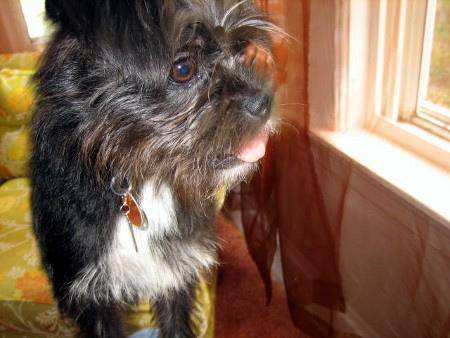

In [31]:
img = display_image_at_idx(20)
img

In [32]:
img.size


(450, 338)

Lets look at sizes of the images

In [33]:
size_d = {k: PIL.Image.open(f"{PATH}/{k}").size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))


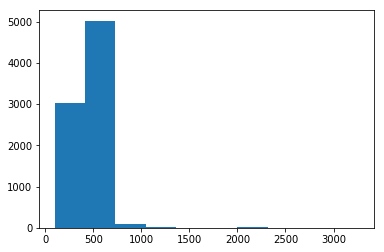

In [34]:
plt.hist(row_sz);

NameError: name 'learn' is not defined

In [73]:
learn = ConvLearner.pretrained(arch, data , precompute=True, ps=0.5)


In [74]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 215/256 [00:02<00:00, 107.39it/s, loss=15.6]


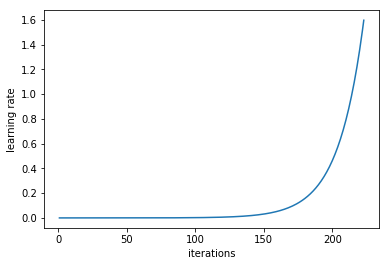

In [75]:
learn.sched.plot_lr()

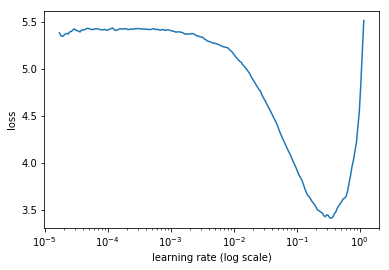

In [76]:
learn.sched.plot()

In [77]:
lr=1e-2

In [78]:
1e-2

0.01

In [79]:
%%time
learn.fit( lrs = lr, n_cycle=5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      2.255523   1.541808   0.686399  
    1      1.344756   0.908879   0.780333                    
    2      1.058285   0.748811   0.793053                    
    3      0.92737    0.641152   0.817025                     
    4      0.83628    0.627169   0.818982                     

CPU times: user 9.65 s, sys: 9.02 s, total: 18.7 s
Wall time: 13.6 s


[array([0.62717]), 0.8189823878254676]

In [80]:
learn.precompute=False
learn.fit(lr, 5, cycle_len=1)


HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.940786   0.57858    0.819961  
    1      0.930605   0.574233   0.814579                    
    2      0.856689   0.565684   0.818493                    
    3      0.833502   0.551289   0.821429                    
    4      0.854461   0.542622   0.824853                    



[array([0.54262]), 0.8248532288461748]

In [81]:
learn.set_data(get_data(299, bs))


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [82]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.723515   0.470253   0.853718  
    1      0.688837   0.463874   0.858121                    
    2      0.685574   0.450891   0.863503                    



[array([0.45089]), 0.8635029355373868]

In [83]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.667966   0.444078   0.857632  
    1      0.691219   0.453369   0.850783                    
    2      0.613771   0.439919   0.857632                    
    3      0.638551   0.441028   0.863992                    
    4      0.651553   0.431005   0.86546                     
    5      0.586868   0.433565   0.863014                    
    6      0.577345   0.430681   0.861546                    



[array([0.43068]), 0.8615459881416739]

In [84]:
%%time

learn.unfreeze()
learn.bn_freeze(True)
learn.fit(lrs=[1e-5, 1e-4, 1e-3], n_cycle=1, cycle_len=2)


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.500288   0.428843   0.862524  
    1      0.44378    0.413784   0.870841                    

CPU times: user 6min 25s, sys: 3min 57s, total: 10min 23s
Wall time: 7min 30s


In [85]:
learn.set_data(get_data(320, bs))
learn.fit(lrs=[1e-5, 1e-4, 1e-3], n_cycle=1, cycle_len=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.459652   0.417067   0.867417  
    1      0.47192    0.416714   0.867906                    



[array([0.41671]), 0.8679060664195604]

In [87]:
?learn.fit

In [88]:
learn.set_data(get_data(340, bs))
learn.fit(lrs=[1e-5, 1e-4, 1e-3], n_cycle=5, cycle_len=2)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.444163   0.414766   0.863503  
    1      0.420902   0.41528    0.862524                    
    2      0.466964   0.414105   0.863503                    
    3      0.447519   0.413637   0.862524                    
    4      0.450654   0.412233   0.863014                    
    5      0.448559   0.411748   0.863014                    
    6      0.443743   0.412178   0.863503                    
    7      0.444555   0.412123   0.863014                    
    8      0.435815   0.412816   0.863503                    
    9      0.40897    0.412666   0.864481                    



[array([0.41267]), 0.8644814088853138]

In [89]:
learn.set_data(get_data(350, bs))
learn.fit(lrs=[1e-5, 1e-4, 1e-3], n_cycle=5, cycle_len=3)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.432499   0.415474   0.863503  
    1      0.44762    0.414073   0.864481                    
    2      0.431448   0.41448    0.863992                    
    3      0.440294   0.414961   0.863992                    
    4      0.436263   0.413731   0.86546                     
    5      0.439363   0.413561   0.864971                    
    6      0.451467   0.41285    0.863992                    
    7      0.427629   0.413906   0.864971                    
    8      0.423549   0.413575   0.86546                     
    9      0.45095    0.413748   0.86546                     
    10     0.432503   0.411967   0.866438                    
    11     0.424365   0.411654   0.866438                    
    12     0.411608   0.411352   0.866438                    
    13     0.431375   0.411443   0.865949                    
    14     0.42915    0.41121    0.865949                    



[array([0.41121]), 0.8659491194904201]

In [ ]:
aa

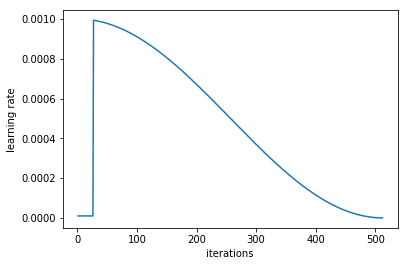

In [53]:
learn.sched.plot_lr()


In [ ]:
learn.set_data(get_data(299,bs))
learn.fit(1e-2,3,cycle_len=1)


In [ ]:
learn.fit(1e-2,3 cycle_len=1, cycle_mult=2)

In [ ]:
??tfms_from_model

In [ ]:
%%time 

log_preds, y = learn.TTA()
#metrics.log_loss(y, np.exp(log_preds)), accuracy(log_preds, y)

In [ ]:
(metrics.log_loss(y,preds), accuracy_np(preds,y))


In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),axis=0)
(metrics.log_loss(y,preds), accuracy_np(preds,y))


In [ ]:
log_preds[0].shape

In [ ]:
y.shape

In [ ]:
accuracy(log_preds, y)

In [ ]:
metrics.log_loss(y, np.exp(log_preds))

In [ ]:
data.classes

In [ ]:
data.test_ds.fnames

In [ ]:
log_preds , y = learn.TTA(is_test = True)
probs = np.exp(log_preds)

In [ ]:
probs.shape

In [ ]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [ ]:
df.insert(0, 'id' , [o[5:-4] for o in data.test_ds.fnames])

In [ ]:
df.head()

In [ ]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM,exist_ok=True)
df.to_csv(f'{PATH}subm.gz', compression='gzip',index=False)

In [ ]:
FileLink(f'{SUBM}subm.gz')

In [ ]:
fn = data.val_ds.fnames[0]

In [ ]:
Image.open(PATH+fn).resize((150,150))

In [ ]:
trn_tfms, val_tfms = tfms_from_model(arch,sz)
ds = FilesIndexArrayDataset([fn],np.array([0] ,val_tfms, PATH))

d1 = DataLoader(ds)
preds = learn.predict_d1(d1)

np.argmax(preds)
                            

In [ ]:
im = trn_tfms(Image.open(PATH+fn))
preds = learn.predict_array(im[None])
np.argmax(preds)